In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from geopy.distance import great_circle
from shapely.geometry import Point
import numpy as np
import pulp
import random

In [2]:
centros_educativos = r"D:\MASTER TIG\SIG\Practica1_localizacion_equipamientos\datos\educapubli_alcala.shp"

In [3]:
df_resultados = pd.read_csv("Distancias.csv")

In [4]:
poblacion = gpd.read_file("df_hexagono_final.shp")

In [5]:
colegios = gpd.read_file(centros_educativos)

<Axes: >

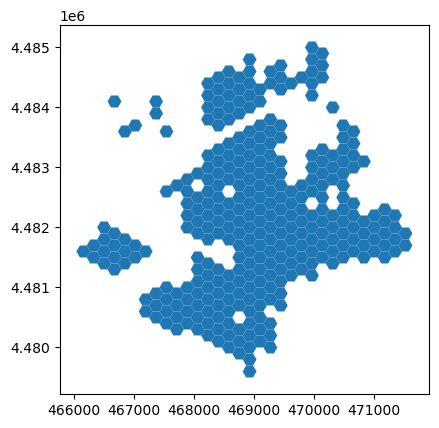

In [6]:
poblacion.plot()

# Generar puntos aleatorios accesibilidad de 15 min

In [7]:
poblacion["accesibi_1"].min()

0.052343374398895

In [8]:
colegios["DS_LARGO"].unique()

array(['Colegio Infantil y Primaria', 'Instituto de Educación Secundaria',
       'Centro de Educación Especial', 'Escuela de Educación Artística',
       'Escuela Oficial Idiomas', 'Escuela de Educación Infantil',
       'Centro Educación de Adultos'], dtype=object)

In [67]:
gdf_filtrado = poblacion[poblacion['accesibili']<0.1]

In [68]:
gdf_filtrado

,id,left,top,right,bottom,pobxparcel,accesibili,accesibi_1,diferencia,geometry,nearest_node
74,1776.0,467429.409103,4.480486e+06,467660.349211,4.480286e+06,928.975904,0.094887,0.101320,0.006432,"POLYGON ((467429.409 4480385.734, 467487.144 4...",3976233245
76,1720.0,467256.204023,4.480586e+06,467487.144130,4.480386e+06,579.616368,0.095519,0.102175,0.006656,"POLYGON ((467256.204 4480485.734, 467313.939 4...",2081286179
77,1662.0,467082.998942,4.480886e+06,467313.939050,4.480686e+06,537.528868,0.076009,0.090466,0.014457,"POLYGON ((467082.999 4480785.734, 467140.734 4...",7126741011
78,1663.0,467082.998942,4.480686e+06,467313.939050,4.480486e+06,1443.306439,0.085312,0.095200,0.009888,"POLYGON ((467082.999 4480585.734, 467140.734 4...",3976230781
79,1718.0,467256.204023,4.480986e+06,467487.144130,4.480786e+06,314.189189,0.097231,0.105225,0.007994,"POLYGON ((467256.204 4480885.734, 467313.939 4...",7126741049
...,...,...,...,...,...,...,...,...,...,...,...
313,2769.0,470547.100557,4.483486e+06,470778.040665,4.483286e+06,387.013352,0.074652,0.086731,0.012079,"POLYGON ((470547.101 4483385.734, 470604.836 4...",5102039806
314,2770.0,470547.100557,4.483286e+06,470778.040665,4.483086e+06,414.171832,0.079566,0.090606,0.011040,"POLYGON ((470547.101 4483185.734, 470604.836 4...",5102039802
315,2768.0,470547.100557,4.483686e+06,470778.040665,4.483486e+06,339.963899,0.065598,0.080242,0.014645,"POLYGON ((470547.101 4483585.734, 470604.836 4...",4111998717
319,2658.0,470200.690396,4.483286e+06,470431.630503,4.483086e+06,59.891304,0.090744,0.099113,0.008369,"POLYGON ((470200.690 4483185.734, 470258.425 4...",259861647


In [10]:
colegios = colegios[["DS_LARGO","geometry"]]

In [11]:
place_name = "Alcala de Henares, España" 
network_type = 'walk'
G = ox.graph_from_place(place_name, network_type=network_type)
# Asumiendo que G es tu grafo de OSMnx
G_proj = ox.project_graph(G)

# Convertir el grafo en GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_proj)

# Cambiar el CRS de los GeoDataFrames
gdf_nodes = gdf_nodes.to_crs("EPSG:25830")
gdf_edges = gdf_edges.to_crs("EPSG:25830")
# Reconstruir el grafo desde los GeoDataFrames
G_proj = ox.graph_from_gdfs(gdf_nodes, gdf_edges)


C:\Users\Jason\AppData\Local\Temp\ipykernel_18988\1633294904.py:14: UserWarning: discarding the gdf_nodes geometry column, though its values differ from the coordinates in the x and y columns
  G_proj = ox.graph_from_gdfs(gdf_nodes, gdf_edges)


In [12]:
poblacion['nearest_node'] = poblacion.geometry.centroid.apply(lambda x: ox.distance.nearest_nodes(G_proj, X=x.x, Y=x.y))

In [13]:
colegios['nearest_node'] = colegios.geometry.apply(lambda x: ox.distance.nearest_nodes(G_proj, X=x.x, Y=x.y))

In [14]:
# Inicializa un DataFrame vacío para almacenar los resultados
columnas = ['index_punto_pob', 'index_col', 'tiempo_viaje']
#minimo_accesibilidad = []
modelos_accesibilidad = []

In [15]:
#df_resultados = pd.DataFrame(columns=columnas)
walk_speed_m_per_s = 1.4

In [81]:
# Asumiendo que 'gdf_filtrado' es tu GeoDataFrame ya filtrado
minx, miny, maxx, maxy = gdf_filtrado.total_bounds

puntos_validos = []

# Asegúrate de que 'gdf_filtrado' esté en un CRS que use metros como unidades
# Si no es el caso, conviértelo a uno adecuado, por ejemplo, un sistema UTM

n_puntos = 1000
max_puntos_validos = 10

while len(puntos_validos) < max_puntos_validos:
    for _ in range(n_puntos):
        if len(puntos_validos) >= max_puntos_validos:
            break
    
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        punto_aleatorio = Point(x, y)
        punto_valido = True
    
        # Comprobar si el punto está dentro de alguno de los polígonos
        if any(punto_aleatorio.within(poligono) for poligono in gdf_filtrado.geometry):
            # Comprobar la distancia con respecto a los puntos válidos existentes
            for punto in puntos_validos:
                if punto_aleatorio.distance(punto) < 500:  # Distancia en metros
                    punto_valido = False
                    break
    
            if punto_valido:
                puntos_validos.append(punto_aleatorio)
gdf_puntos = gpd.GeoDataFrame(geometry=puntos_validos)

In [105]:
len(puntos_validos)

10

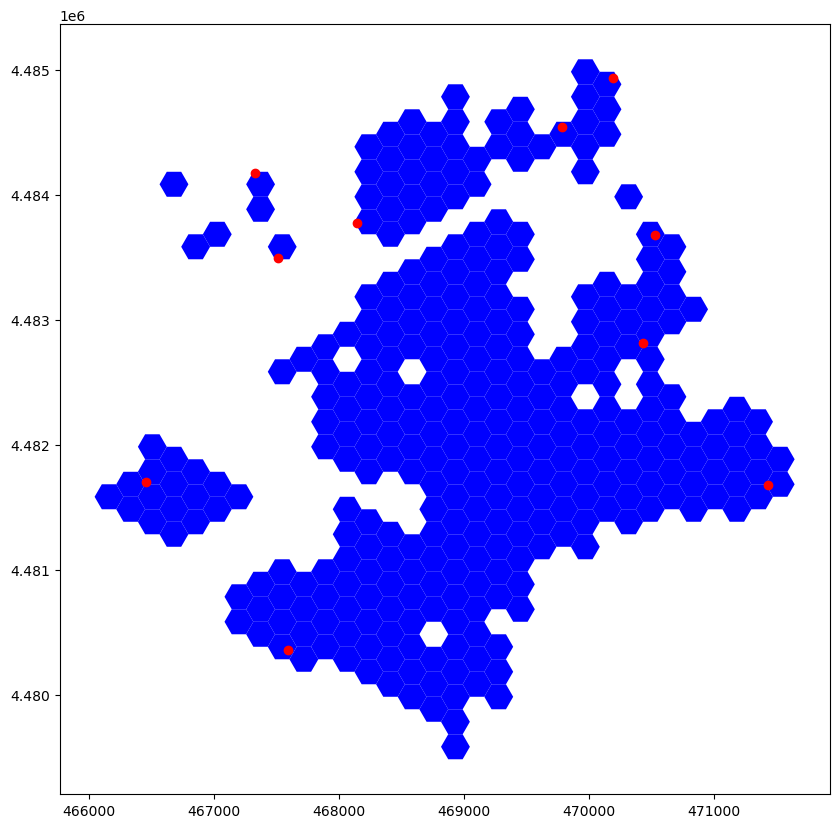

In [82]:
ax = poblacion.plot(color='blue', figsize=(10, 10))

# Graficar el segundo GeoDataFrame en el mismo eje
gdf_puntos.plot(ax=ax, color='red')

# Mostrar el gráfico
plt.show()

In [83]:
# Crear un GeoDataFrame con los puntos válidos

gdf_puntos["DS_LARGO"] = "Instituto de Educación Secundaria" 
gdf_puntos['nearest_node'] = gdf_puntos.geometry.apply(lambda x: ox.distance.nearest_nodes(G_proj, X=x.x, Y=x.y))


In [84]:
gdf_puntos.to_file("colegios_nuevos.shp")

C:\Users\Jason\AppData\Local\Temp\ipykernel_18988\3676326362.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_puntos.to_file("colegios_nuevos.shp")


In [85]:
colegios =  pd.concat([colegios, gdf_puntos])

C:\Users\Jason\.conda\envs\advprog\Lib\site-packages\geopandas\array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as ETRS89 / UTM zone 30N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [86]:
colegios.reset_index(inplace=True, drop=False)

In [87]:
colegios['capacidad'] = colegios['DS_LARGO'].apply(lambda x: 800 if x == 'Colegio Infantil, Primaria y Secundaria' 
                                            else 400 if x == 'Colegio Infantil y Primaria' 
                                            else 540 if x == 'Instituto de Educación Secundaria' 
                                            else 250 if x == 'Escuela de Educación Infantil' 
                                            else 0) 

In [88]:
df_resultados = pd.DataFrame(columns=columnas)

# Accesibilidad general

In [89]:

for index_punto_pob, punto_pob in poblacion.iterrows():
    print("Calculo de tiempo de viaje para el hexagono {0}".format(index_punto_pob))
    for index_col, punto_col in colegios.iterrows():
        try:
            tiempo_viaje = (nx.shortest_path_length(G_proj, punto_pob.nearest_node, punto_col.nearest_node, weight='length'))/walk_speed_m_per_s
            resultado_df = pd.DataFrame([{
                'index_punto_pob': index_punto_pob,
                'index_col': index_col,
                'tiempo_viaje': tiempo_viaje
            }])
            
            # Concatena 'resultado_df' con 'df_resultados'
            df_resultados = pd.concat([df_resultados, resultado_df], ignore_index=True)
            #modelos_accesibilidad.append(df_resultados)

        except nx.NetworkXNoPath:
            print("Error al momento de hace el tiempo de viaje")
            continue

Calculo de tiempo de viaje para el hexagono 0


C:\Users\Jason\AppData\Local\Temp\ipykernel_18988\1250346732.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_resultados = pd.concat([df_resultados, resultado_df], ignore_index=True)


Calculo de tiempo de viaje para el hexagono 1
Calculo de tiempo de viaje para el hexagono 2
Calculo de tiempo de viaje para el hexagono 3
Calculo de tiempo de viaje para el hexagono 4
Calculo de tiempo de viaje para el hexagono 5
Calculo de tiempo de viaje para el hexagono 6
Calculo de tiempo de viaje para el hexagono 7
Calculo de tiempo de viaje para el hexagono 8
Calculo de tiempo de viaje para el hexagono 9
Calculo de tiempo de viaje para el hexagono 10
Calculo de tiempo de viaje para el hexagono 11
Calculo de tiempo de viaje para el hexagono 12
Calculo de tiempo de viaje para el hexagono 13
Calculo de tiempo de viaje para el hexagono 14
Calculo de tiempo de viaje para el hexagono 15
Calculo de tiempo de viaje para el hexagono 16
Calculo de tiempo de viaje para el hexagono 17
Calculo de tiempo de viaje para el hexagono 18
Calculo de tiempo de viaje para el hexagono 19
Calculo de tiempo de viaje para el hexagono 20
Calculo de tiempo de viaje para el hexagono 21
Calculo de tiempo de v

# Aplicación de la Función de Decaimiento en la Accesibilidad de la Oferta (Colegios) a 15 minutos

In [90]:
import numpy as np

def funcion_decaimiento(tiempo_viaje, tiempo_max):
    # Asumiendo que tiempo_max es el máximo tiempo de viaje en tu análisis (por ejemplo, 45*60 para 45 minutos)
    return np.exp(-tiempo_viaje / tiempo_max)

In [91]:
colegios['accesibilidad_15min'] = 0

for index_colegio, colegio in colegios.iterrows():
    accesibilidad_colegio = 0
    suma_ponderada_poblacion = 0 
    df_colegio = df_resultados[df_resultados['index_col'] == index_colegio]
    
    for _, row in df_colegio.iterrows():
        # Obtener la población del punto de demanda
        poblacion_accesible = poblacion.loc[row['index_punto_pob'], 'pobxparcel']
        
        # Aplicar la función de decaimiento al tiempo de viaje
        factor_decaimiento = funcion_decaimiento(row['tiempo_viaje'], 900)  # Usando 15 minutos como tiempo máximo
        # print(row['tiempo_viaje'])
        suma_ponderada_poblacion += poblacion_accesible * factor_decaimiento
        # Ajustar la población por el factor de decaimiento
        #accesibilidad_colegio += poblacion_accesible * factor_decaimiento
    # Calcular la accesibilidad del colegio como capacidad / suma ponderada de población
    if suma_ponderada_poblacion > 0:  # Para evitar la división por cero
        colegios.at[index_colegio, 'accesibilidad_15min'] = colegio['capacidad'] / suma_ponderada_poblacion
    else:
        colegios.at[index_colegio, 'accesibilidad_15min'] = 0

C:\Users\Jason\AppData\Local\Temp\ipykernel_18988\1979396067.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.007458814438543725' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  colegios.at[index_colegio, 'accesibilidad_15min'] = colegio['capacidad'] / suma_ponderada_poblacion


In [92]:
colegios.head(2)

,index,DS_LARGO,geometry,nearest_node,capacidad,accesibilidad_15min
0,0,Colegio Infantil y Primaria,POINT (468386.000 4482313.000),259719695,400,0.007459
1,1,Colegio Infantil y Primaria,POINT (468658.000 4481259.000),5687847305,400,0.006315


# Aplicación de la Función de Decaimiento en la Accesibilidad de la Demanda (Puntos de Población) a 15 min 

In [93]:
poblacion['accesibilidad_15min'] = 0

for index_punto, punto in poblacion.iterrows():
    accesibilidad_punto = 0
    suma_ponderada_poblacion = 0 
    df_punto = df_resultados[df_resultados['index_punto_pob'] == index_punto]
    poblacion_accesible = poblacion.loc[row['index_punto_pob'], 'pobxparcel']
    for _, row in df_punto.iterrows():
        # Obtener la accesibilidad del colegio
        print(row['index_col'])
        accesibilidad_colegio = colegios.loc[row['index_col'], 'accesibilidad_15min']
        
        # Aplicar la función de decaimiento al tiempo de viaje
        factor_decaimiento = funcion_decaimiento(row['tiempo_viaje'], 900)  # Usando 45 minutos como tiempo máximo
        accesibilidad_punto += accesibilidad_colegio * factor_decaimiento
        # Ajustar la accesibilidad del colegio por el factor de decaimiento
    poblacion.at[index_punto, 'accesibilidad_15min'] = accesibilidad_punto

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


C:\Users\Jason\AppData\Local\Temp\ipykernel_18988\2309353112.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1636201753868398' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  poblacion.at[index_punto, 'accesibilidad_15min'] = accesibilidad_punto


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


In [94]:
poblacion.head(5)

,id,left,top,right,bottom,pobxparcel,accesibili,accesibi_1,diferencia,geometry,nearest_node,accesibilidad_15min
0,2108.0,468468.639588,4.481286e+06,468699.579696,4.481086e+06,204.968593,0.143180,0.134219,-0.008960,"POLYGON ((468468.640 4481185.734, 468526.375 4...",7126654298,0.163620
1,2164.0,468641.844669,4.481386e+06,468872.784776,4.481186e+06,297.323697,0.147772,0.138060,-0.009712,"POLYGON ((468641.845 4481285.734, 468699.580 4...",7096895724,0.170111
2,2165.0,468641.844669,4.481186e+06,468872.784776,4.480986e+06,335.871067,0.142804,0.135414,-0.007390,"POLYGON ((468641.845 4481085.734, 468699.580 4...",422999894,0.163655
3,2166.0,468641.844669,4.480986e+06,468872.784776,4.480786e+06,737.003226,0.140759,0.132384,-0.008375,"POLYGON ((468641.845 4480885.734, 468699.580 4...",3631502282,0.159032
4,2219.0,468815.049750,4.481486e+06,469045.989857,4.481286e+06,348.866143,0.140579,0.135604,-0.004975,"POLYGON ((468815.050 4481385.734, 468872.785 4...",2839975264,0.162831


In [95]:
poblacion.to_file("df_hexagono_final_propuesta.shp")

C:\Users\Jason\AppData\Local\Temp\ipykernel_18988\1684527580.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  poblacion.to_file("df_hexagono_final_propuesta.shp")


In [98]:
import matplotlib.pyplot as plt

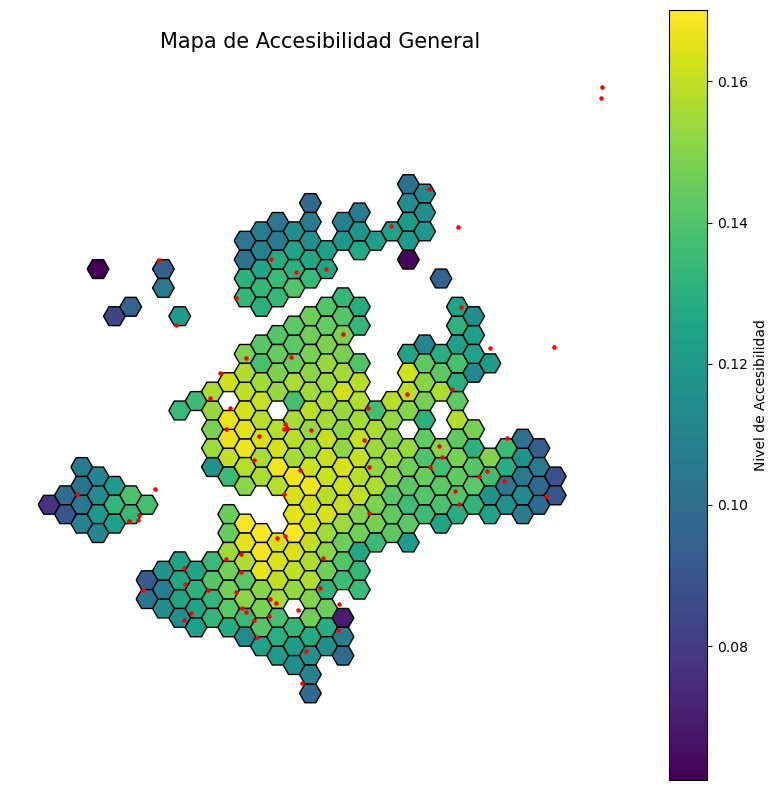

In [99]:
# Configurar la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 10))

# Graficar el GeoDataFrame, clasificando por 'accesibilidad'
poblacion.plot(column='accesibilidad_15min', ax=ax, legend=True,
                       cmap='viridis', edgecolor='k', legend_kwds={'label': "Nivel de Accesibilidad"})

colegios.plot(ax=ax, marker='o', color='red', markersize=5)
# Añadir títulos y etiquetas
ax.set_title('Mapa de Accesibilidad General', fontsize=15)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

# Omitir los ejes para un mapa más limpio
ax.set_axis_off()

# Mostrar el mapa
plt.show()


# Aplicación de la Función de Decaimiento en la Accesibilidad de la Demanda (Puntos de Población) a 30 min 

In [100]:
colegios['accesibilidad_30min'] = 0

for index_colegio, colegio in colegios.iterrows():
    accesibilidad_colegio = 0
    suma_ponderada_poblacion = 0 
    df_colegio = df_resultados[df_resultados['index_col'] == index_colegio]
    
    for _, row in df_colegio.iterrows():
        # Obtener la población del punto de demanda
        poblacion_accesible = poblacion.loc[row['index_punto_pob'], 'pobxparcel']
        
        # Aplicar la función de decaimiento al tiempo de viaje
        factor_decaimiento = funcion_decaimiento(row['tiempo_viaje'], 1800)  # Usando 15 minutos como tiempo máximo
        # print(row['tiempo_viaje'])
        suma_ponderada_poblacion += poblacion_accesible * factor_decaimiento
        # Ajustar la población por el factor de decaimiento
        #accesibilidad_colegio += poblacion_accesible * factor_decaimiento
    # Calcular la accesibilidad del colegio como capacidad / suma ponderada de población
    if suma_ponderada_poblacion > 0:  # Para evitar la división por cero
        colegios.at[index_colegio, 'accesibilidad_30min'] = colegio['capacidad'] / suma_ponderada_poblacion
    else:
        colegios.at[index_colegio, 'accesibilidad_30min'] = 0
    #df_centros.at[index_colegio, 'accesibilidad'] = accesibilidad_colegio

C:\Users\Jason\AppData\Local\Temp\ipykernel_18988\1945808944.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.004096144844153113' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  colegios.at[index_colegio, 'accesibilidad_30min'] = colegio['capacidad'] / suma_ponderada_poblacion


# Aplicación de la Función de Decaimiento en la Accesibilidad de la Demanda (Puntos de Población) a 30 min 

In [101]:
poblacion['accesibilidad_30min'] = 0

for index_punto, punto in poblacion.iterrows():
    accesibilidad_punto = 0
    suma_ponderada_poblacion = 0 
    df_punto = df_resultados[df_resultados['index_punto_pob'] == index_punto]
    poblacion_accesible = poblacion.loc[row['index_punto_pob'], 'pobxparcel']
    for _, row in df_punto.iterrows():
        # Obtener la accesibilidad del colegio
        accesibilidad_colegio = colegios.loc[row['index_col'], 'accesibilidad_30min']
        
        # Aplicar la función de decaimiento al tiempo de viaje
        factor_decaimiento = funcion_decaimiento(row['tiempo_viaje'], 1800)  # Usando 45 minutos como tiempo máximo
        accesibilidad_punto += accesibilidad_colegio * factor_decaimiento
        # Ajustar la accesibilidad del colegio por el factor de decaimiento
    poblacion.at[index_punto, 'accesibilidad_30min'] = accesibilidad_punto

C:\Users\Jason\AppData\Local\Temp\ipykernel_18988\867271286.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15961999374471678' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  poblacion.at[index_punto, 'accesibilidad_30min'] = accesibilidad_punto


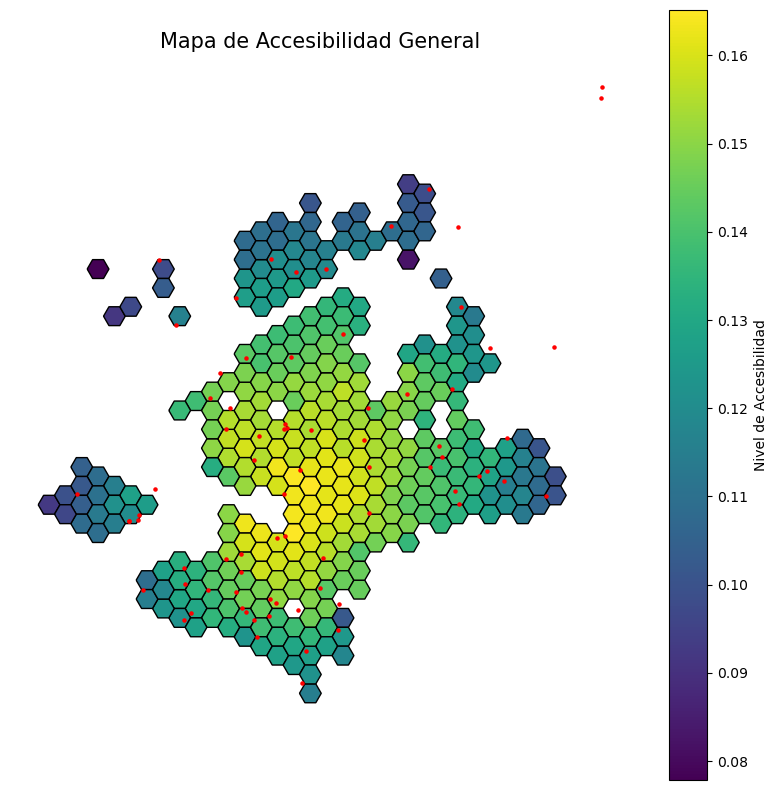

In [102]:
# Configurar la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 10))


poblacion.plot(column='accesibilidad_30min', ax=ax, legend=True,
                       cmap='viridis', edgecolor='k', legend_kwds={'label': "Nivel de Accesibilidad"})

colegios.plot(ax=ax, marker='o', color='red', markersize=5)
# Añadir títulos y etiquetas
ax.set_title('Mapa de Accesibilidad General', fontsize=15)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

# Omitir los ejes para un mapa más limpio
ax.set_axis_off()

# Mostrar el mapa
plt.show()

In [103]:
poblacion.to_file("df_hexagono_final_propuesta.shp")

C:\Users\Jason\AppData\Local\Temp\ipykernel_18988\1684527580.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  poblacion.to_file("df_hexagono_final_propuesta.shp")


# Cantidad de hexagonos por accesibilidad

In [ ]:
df_hexagonos_es1 = gpd.read_file("df_hexagono_final.shp")

In [ ]:
df_hexagonos_es1.head(10)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que 'df' es tu DataFrame y ya contiene tus datos

plt.figure(figsize=(10, 6))  # Define el tamaño del gráfico
plt.scatter(df_hexagonos_es1['accesibili'], df_hexagonos_es1['pobxparcel'], alpha=0.5)  # Crea un scatter plot
plt.title('Población por Accesibilidad 15 minutos')  # Título del gráfico
plt.xlabel('Accesibilidad')  # Etiqueta eje X
plt.ylabel('Población')  # Etiqueta eje Y
plt.grid(True)  # Añade una cuadrícula al gráfico
plt.show()  # Muestra el gráfico


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que 'df' es tu DataFrame y ya contiene tus datos

plt.figure(figsize=(10, 6))  # Define el tamaño del gráfico
plt.scatter(df_hexagonos_es1['accesibi_1'], df_hexagonos_es1['pobxparcel'], alpha=0.5)  # Crea un scatter plot
plt.title('Población por Accesibilidad 30 minutos')  # Título del gráfico
plt.xlabel('Accesibilidad')  # Etiqueta eje X
plt.ylabel('Población')  # Etiqueta eje Y
plt.grid(True)  # Añade una cuadrícula al gráfico
plt.show()  # Muestra el gráfico

In [106]:
poblacion.head(2)

,id,left,top,right,bottom,pobxparcel,accesibili,accesibi_1,diferencia,geometry,nearest_node,accesibilidad_15min,accesibilidad_30min
0,2108.0,468468.639588,4.481286e+06,468699.579696,4.481086e+06,204.968593,0.143180,0.134219,-0.008960,"POLYGON ((468468.640 4481185.734, 468526.375 4...",7126654298,0.163620,0.159620
1,2164.0,468641.844669,4.481386e+06,468872.784776,4.481186e+06,297.323697,0.147772,0.138060,-0.009712,"POLYGON ((468641.845 4481285.734, 468699.580 4...",7096895724,0.170111,0.164935


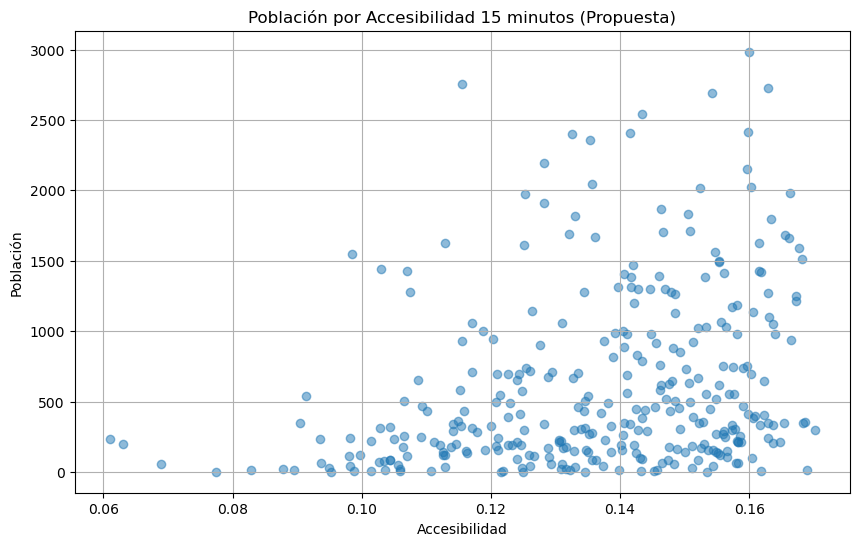

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que 'df' es tu DataFrame y ya contiene tus datos

plt.figure(figsize=(10, 6))  # Define el tamaño del gráfico
plt.scatter(poblacion['accesibilidad_15min'], poblacion['pobxparcel'], alpha=0.5)  # Crea un scatter plot
plt.title('Población por Accesibilidad 15 minutos (Propuesta)')  # Título del gráfico
plt.xlabel('Accesibilidad')  # Etiqueta eje X
plt.ylabel('Población')  # Etiqueta eje Y
plt.grid(True)  # Añade una cuadrícula al gráfico
plt.show()  # Muestra el gráfico


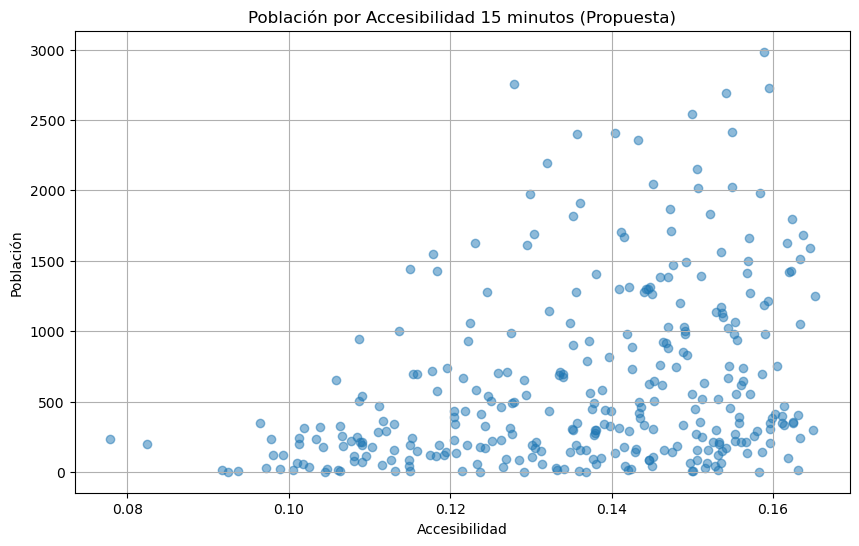

In [110]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que 'df' es tu DataFrame y ya contiene tus datos

plt.figure(figsize=(10, 6))  # Define el tamaño del gráfico
plt.scatter(poblacion['accesibilidad_30min'], poblacion['pobxparcel'], alpha=0.5)  # Crea un scatter plot
plt.title('Población por Accesibilidad 15 minutos (Propuesta)')  # Título del gráfico
plt.xlabel('Accesibilidad')  # Etiqueta eje X
plt.ylabel('Población')  # Etiqueta eje Y
plt.grid(True)  # Añade una cuadrícula al gráfico
plt.show()  # Muestra el gráfico


In [ ]:
for i in range(0,5):
    print(i)
    minx, miny, maxx, maxy = gdf_filtrado.total_bounds
    
    # Lista para guardar los puntos que cumplen la condición
    puntos_validos = []
    df_resultados = pd.DataFrame(columns=columnas)
    # Número de puntos aleatorios a generar
    n_puntos = 40
    # Generar puntos aleatorios y comprobar si intersectan con los polígonos filtrados
    for _ in range(n_puntos):
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        punto_aleatorio = Point(x, y)
        
        # Comprobar si el punto intersecta con alguno de los polígonos filtrados
        for poligono in gdf_filtrado.geometry:
            if punto_aleatorio.within(poligono):
                puntos_validos.append(punto_aleatorio)
                break
    
    # Crear un GeoDataFrame con los puntos válidos
    gdf_puntos = gpd.GeoDataFrame(geometry=puntos_validos)
    gdf_puntos["DS_LARGO"] = "Instituto de Educación Secundaria" 
    gdf_puntos['nearest_node'] = gdf_puntos.geometry.centroid.apply(lambda x: ox.distance.nearest_nodes(G_proj, X=x.x, Y=x.y))
    colegios =  pd.concat([colegios, gdf_puntos])
    colegios['capacidad'] = colegios['DS_LARGO'].apply(lambda x: 800 if x == 'Colegio Infantil, Primaria y Secundaria' 
                                                else 400 if x == 'Colegio Infantil y Primaria' 
                                                else 540 if x == 'Instituto de Educación Secundaria' 
                                                else 250 if x == 'Escuela de Educación Infantil' 
                                                else 0) 
    for index_punto_pob, punto_pob in poblacion.iterrows():
        print("Calculo de tiempo de viaje para el hexagono {0}".format(index_punto_pob))
        for index_col, punto_col in colegios.iterrows():
            try:
                tiempo_viaje = (nx.shortest_path_length(G_proj, punto_pob.nearest_node, punto_col.nearest_node, weight='length'))/walk_speed_m_per_s
                resultado_df = pd.DataFrame([{
                    'index_punto_pob': index_punto_pob,
                    'index_col': index_col,
                    'tiempo_viaje': tiempo_viaje
                }])
                
                # Concatena 'resultado_df' con 'df_resultados'
                df_resultados = pd.concat([df_resultados, resultado_df], ignore_index=True)
                modelos_accesibilidad.append(df_resultados)

            except nx.NetworkXNoPath:
                print("Error al momento de hace el tiempo de viaje")
                continue

In [ ]:
modelos_accesibilidad

# Filtrar los polígonos con valor de atributo mayor a 20
# Determinar los límites para generar puntos aleatorios
minx, miny, maxx, maxy = gdf_filtrado.total_bounds

# Lista para guardar los puntos que cumplen la condición
puntos_validos = []

# Número de puntos aleatorios a generar
n_puntos = 40

# Generar puntos aleatorios y comprobar si intersectan con los polígonos filtrados
for _ in range(n_puntos):
    x = random.uniform(minx, maxx)
    y = random.uniform(miny, maxy)
    punto_aleatorio = Point(x, y)
    
    # Comprobar si el punto intersecta con alguno de los polígonos filtrados
    for poligono in gdf_filtrado.geometry:
        if punto_aleatorio.within(poligono):
            puntos_validos.append(punto_aleatorio)
            break

# Crear un GeoDataFrame con los puntos válidos
gdf_puntos = gpd.GeoDataFrame(geometry=puntos_validos)

In [ ]:
gdf_puntos.plot()

In [ ]:
gdf_puntos.head(2)

In [ ]:
gdf_puntos["DS_LARGO"] = "Instituto de Educación Secundaria" 

In [ ]:
gdf_puntos.head(2)

In [ ]:
colegios['capacidad'] = colegios['DS_LARGO'].apply(lambda x: 800 if x == 'Colegio Infantil, Primaria y Secundaria' 
                                            else 400 if x == 'Colegio Infantil y Primaria' 
                                            else 540 if x == 'Instituto de Educación Secundaria' 
                                            else 250 if x == 'Escuela de Educación Infantil' 
                                            else 0) 

In [ ]:
colegios.head(2)

intersection = gpd.overlay(gdf_puntos, poblacion, how='intersection')

In [ ]:
#columnas = ['index_punto_pob', 'index_col', 'tiempo_viaje']
#df_resultados = pd.DataFrame(columns=columnas)
walk_speed_m_per_s = 1.4

In [ ]:
#columnas = ['index_punto_pob', 'index_col', 'tiempo_viaje']
#df_resultados = pd.DataFrame(columns=columnas)

#colegios['nearest_node'] = colegios.geometry.centroid.apply(lambda x: ox.distance.nearest_nodes(G_proj, X=x.x, Y=x.y))

In [ ]:
for index_punto_pob, punto_pob in poblacion.iterrows():
    print("Calculo de tiempo de viaje para el hexagono {0}".format(index_punto_pob))
    for index_col, punto_col in gdf_puntos.iterrows():
        try:
            tiempo_viaje = (nx.shortest_path_length(G_proj, punto_pob.nearest_node, punto_col.nearest_node, weight='length'))/walk_speed_m_per_s
            resultado_df = pd.DataFrame([{
                'index_punto_pob': index_punto_pob,
                'index_col': index_col,
                'tiempo_viaje': tiempo_viaje
            }])
            
            # Concatena 'resultado_df' con 'df_resultados'
            df_resultados = pd.concat([df_resultados, resultado_df], ignore_index=True)
        except nx.NetworkXNoPath:
            print("Error al momento de hace el tiempo de viaje")
            continue

In [ ]:
poblacion.head(2)

In [ ]:
colegios.head(2)

In [ ]:
colegios[colegios["index"]==67]

In [ ]:
poblacion = poblacion.reset_index()
colegios = colegios.reset_index()

In [ ]:
df_resultados.head(5)

In [ ]:
df_colegios = pd.read_csv("Distancias.csv")

In [ ]:
df_distancias = df_colegios.add(df_resultados, fill_value=0)